# Wykrywanie i obliczanie działań matematycznych w postaci elektronicznej za pomocą konwolucyjnej sieci neuronowej (CNN)

In [5]:
import matplotlib.pyplot as plt                         # Tworzenie wykresów
import numpy as np                                      # Do operacji na zbiorze danych
import PIL                                              # Do otwierania obrazów w kodzie
import tensorflow as tf                                 # Główny framework machine-learningowy do tworzenia sieci neuronowych
import keras                                            # Używany jako 'interfejs' dla tensorflow
from keras import layers                                # Umożliwia budowanie sieci neuronowych poprzez dodawanie kolejnych warstw
from keras.models import Sequential                     # Umożliwia tworzenie sekwencyjnego modelu uczenia maszynowego
from keras.utils import image_dataset_from_directory    # Narzędzie do wczytywania danych w formie obrazów
import pathlib                                          # Do wczytywania danych ze ścieżki
tf.__version__

'2.15.0'

In [6]:
data_path = pathlib.Path("C:/Users/Mateusz/Desktop/data/archive/data/extracted_images") # Zmienna przechowywująca ścieżkę w której znajdują się dane
print(f"\n{data_path}")


C:\Users\Mateusz\Desktop\data\archive\data\extracted_images


In [7]:
image_count = len(list(data_path.glob('*/*.jpg'))) # Zmienna przechowywująca ilość obrazów w zbiorze danych
print(image_count)

186134


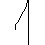

In [8]:
one = list(data_path.glob('1/*')) # Przykładowy obraz ze zbioru danych
PIL.Image.open(str(one[0]))

# Tworzenie treningowego datasetu dzięki keras.

In [16]:
BATCH_SIZE = 200     # Ilość obrazów przetworzonych na raz podczas jednej iteracji danych
IMG_HEIGHT = 45     # Wysokość obrazu ze zbioru danych
IMG_WIDTH = 45      # Szerokość obrazu ze zbioru danych
SEED = 68           # Zmienna zachowująca ciągłość we wszystkich przypadkowych zdarzeniach, co pozwala na reprodukowalność wyników

training_dataset = image_dataset_from_directory(
    data_path,
    batch_size = BATCH_SIZE,
    image_size = (IMG_HEIGHT, IMG_WIDTH),
    seed = SEED,
    color_mode='grayscale', # Obrazy zostały przekonwertowane na 'grayscale', jako że występują one jedyne w dwóch kolorach - czarny i biały
    validation_split = 0.2,
    subset = "training",
)

Found 186134 files belonging to 16 classes.
Using 148908 files for training.


# Tworzenie walidacyjnego datasetu.

In [17]:
validation_dataset = image_dataset_from_directory(
    data_path,
    batch_size=BATCH_SIZE,
    image_size = (IMG_HEIGHT, IMG_WIDTH),
    seed=SEED,
    color_mode="grayscale",
    validation_split=0.2,
    subset="validation",
)

Found 186134 files belonging to 16 classes.
Using 37226 files for validation.


In [18]:
class_names = training_dataset.class_names # Zmienna przechowywująca występujące klasy obrazów. Nazywane są one po folderach w których się znajdują.
print(class_names)
num_classes = len(class_names)

['(', ')', '+', '-', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'div', 'times']


# Wygenerowanie dziewięciu przykładowych obrazów z datasetu treningowego.

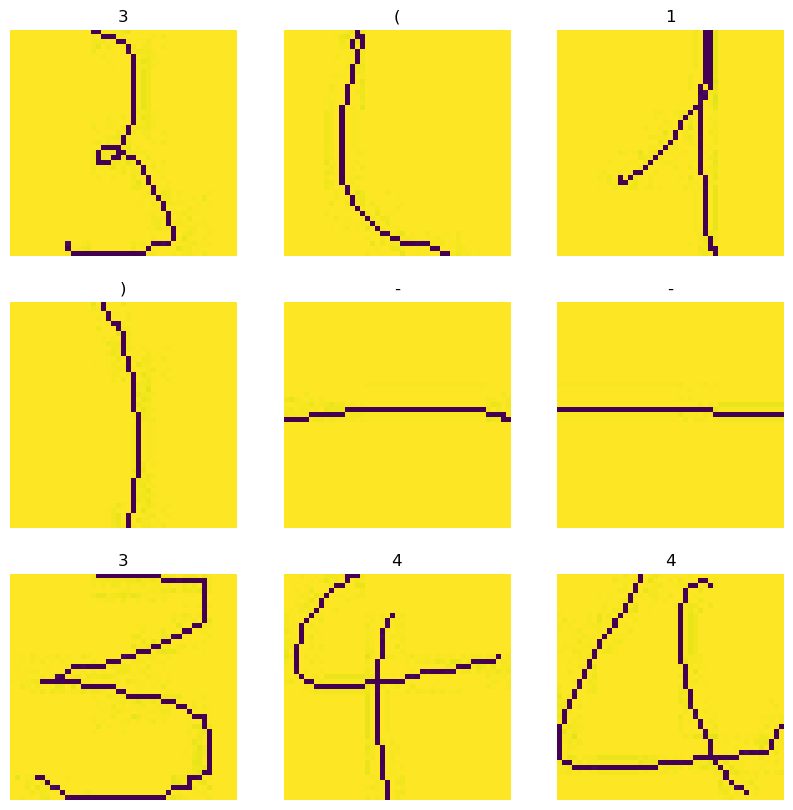

In [19]:
plt.figure(figsize=(10, 10))
for images, labels in training_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype('uint8'))
        plt.title(class_names[labels[i]])
        plt.axis("off")

# Każdy batch posiada 200 obrazów 45x45 z jednym kanałem koloru (grayscale).

In [20]:
for image_batch, labels_batch in training_dataset: 
  print(image_batch.shape) 
  print(labels_batch.shape) 
  break

(200, 45, 45, 1)
(200,)


# Tworzenie modelu

In [21]:
model = Sequential([
    layers.Rescaling(1./255, input_shape=(IMG_HEIGHT, IMG_WIDTH, 1)),     # Tworzy warstwę 'normalizacji', która normalizuje wartości pikseli obrazów poprzez podzielenie ich przez 255. Dobra praktyka dla lepszej wydajności.
    layers.Conv2D(16, 3, padding='same', activation='relu'),              # Warstwa konwolucyjna, 16 neuronów z filtrami o rozmiarze 3x3, funkcja Rectified Linear Unit (wartosci ujemne zamieniane na zero)
    layers.MaxPooling2D(),                                                # Operacja poolingowa (zmnieszjająca rozmiar przestrzenny danych po wyjściu z warstwy konwolucyjnej)
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.2),
    layers.Flatten(),                                                     # Warstwa spłaszczająca obrazy do 1D (ciąg pikseli). Zawsze występuje przed warstwą gęstą.
    layers.Dense(128, activation='relu'),                                 # Warstwa gęsta (fully connected layer) posiadająca 128 neuronów. Jest to warstwa wyjściowa moedlu
    layers.Dense(num_classes, name='output')                              # Warstwa przechowywująca klasy. Klasyfikuje ona obrazy.
])

C:\Users\Mateusz\anaconda3\Lib\site-packages\keras\layers\preprocessing\tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


# Kompilacja modelu

In [22]:
model.compile(optimizer='adam',
              loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 45, 45, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 45, 45, 16)     │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 22, 22, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 22, 22, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 11, 11, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 11, 11, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1600)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 16)             │         2,064 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 230,288 (899.56 KB)

 Trainable params: 230,288 (899.56 KB)

 Non-trainable params: 0 (0.00 B)

# Trening modelu

In [71]:
epochs = 10
history = model.fit(
  training_dataset,
  validation_data=validation_dataset,
  epochs=epochs
)

Epoch 1/10
809/809 ━━━━━━━━━━━━━━━━━━━━ 36s 44ms/step - accuracy: 0.8107 - loss: 0.6647 - val_accuracy: 0.9750 - val_loss: 0.0863
Epoch 2/10
809/809 ━━━━━━━━━━━━━━━━━━━━ 34s 41ms/step - accuracy: 0.9776 - loss: 0.0756 - val_accuracy: 0.9848 - val_loss: 0.0532
Epoch 3/10
809/809 ━━━━━━━━━━━━━━━━━━━━ 35s 43ms/step - accuracy: 0.9834 - loss: 0.0558 - val_accuracy: 0.9874 - val_loss: 0.0433
Epoch 4/10
809/809 ━━━━━━━━━━━━━━━━━━━━ 34s 42ms/step - accuracy: 0.9867 - loss: 0.0435 - val_accuracy: 0.9898 - val_loss: 0.0345
Epoch 5/10
809/809 ━━━━━━━━━━━━━━━━━━━━ 34s 42ms/step - accuracy: 0.9884 - loss: 0.0373 - val_accuracy: 0.9902 - val_loss: 0.0320
Epoch 6/10
809/809 ━━━━━━━━━━━━━━━━━━━━ 34s 41ms/step - accuracy: 0.9897 - loss: 0.0324 - val_accuracy: 0.9911 - val_loss: 0.0301
Epoch 7/10
809/809 ━━━━━━━━━━━━━━━━━━━━ 37s 46ms/step - accuracy: 0.9901 - loss: 0.0297 - val_accuracy: 0.9916 - val_loss: 0.0261
Epoch 8/10
809/809 ━━━━━━━━━━━━━━━━━━━━ 35s 43ms/step - accuracy: 0.9912 - loss: 0.0269 - 

# Strata danych walidacyjnych wygląda zadowalająco.

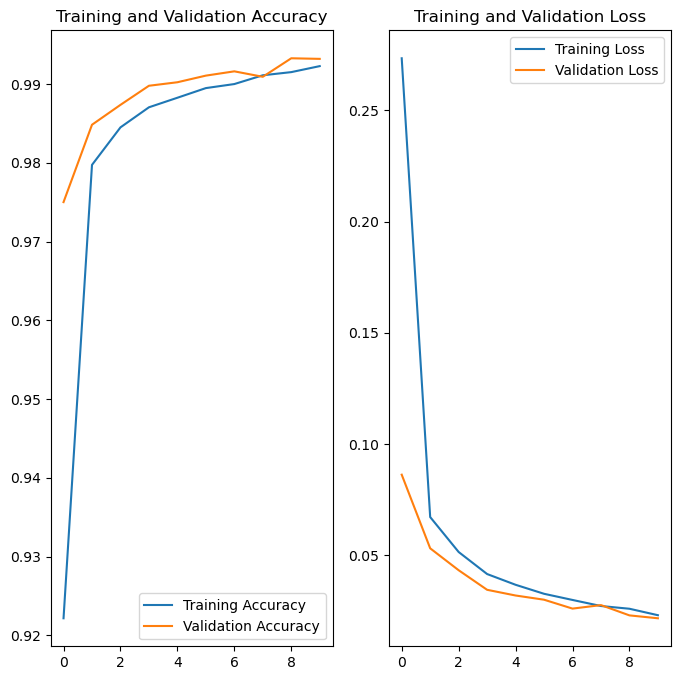

In [72]:
acc = history.history['accuracy'] 
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# Model poprawnie rozpoznał liczbę.

In [73]:
img = PIL.Image.open('examples/seven.png').convert('L') 
img = img.resize((IMG_WIDTH, IMG_HEIGHT))
img_array = keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
This image most likely belongs to 7 with a 100.00 percent confidence.


In [74]:
predictions_x = model.predict(validation_dataset)

203/203 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step


# Na koniec tworzymy tzw. macierz konfuzji aby ocenić poprawność działania modelu.

In [75]:
true_labels = []
predicted_labels = []

for images, labels in validation_dataset:
    predictions = model.predict(images)
    predicted_indices = np.argmax(predictions, axis=1)
    true_labels.extend(labels.numpy())
    predicted_labels.extend(predicted_indices)

true_labels = np.array(true_labels)
predicted_labels = np.array(predicted_labels)
confusion_matrix = tf.math.confusion_matrix(labels=true_labels, predictions=predicted_labels, num_classes=num_classes)

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
7/7 ━━━━━━━━

In [76]:
confusion_matrix

<tf.Tensor: shape=(20, 20), dtype=int32, numpy=
array([[ 260,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0],
       [   0, 2796,    0,    0,    3,    0,   64,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0],
       [   0,    0, 2732,    0,    0,    0,   35,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0],
       [   0,    0,    0, 5082,    0,    0,    5,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0],
       [   0,    1,    0,    1, 6770,    0,    1,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0],
       [   0,    1,    1,    0,    0, 1372,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    3,    0,    0,    0],
       [   0,  122,    7,    1,    0,    0, 5130,    0,    0,    2,    0,
           0,    0,    0,    0,    0,    0,    0,    0, 

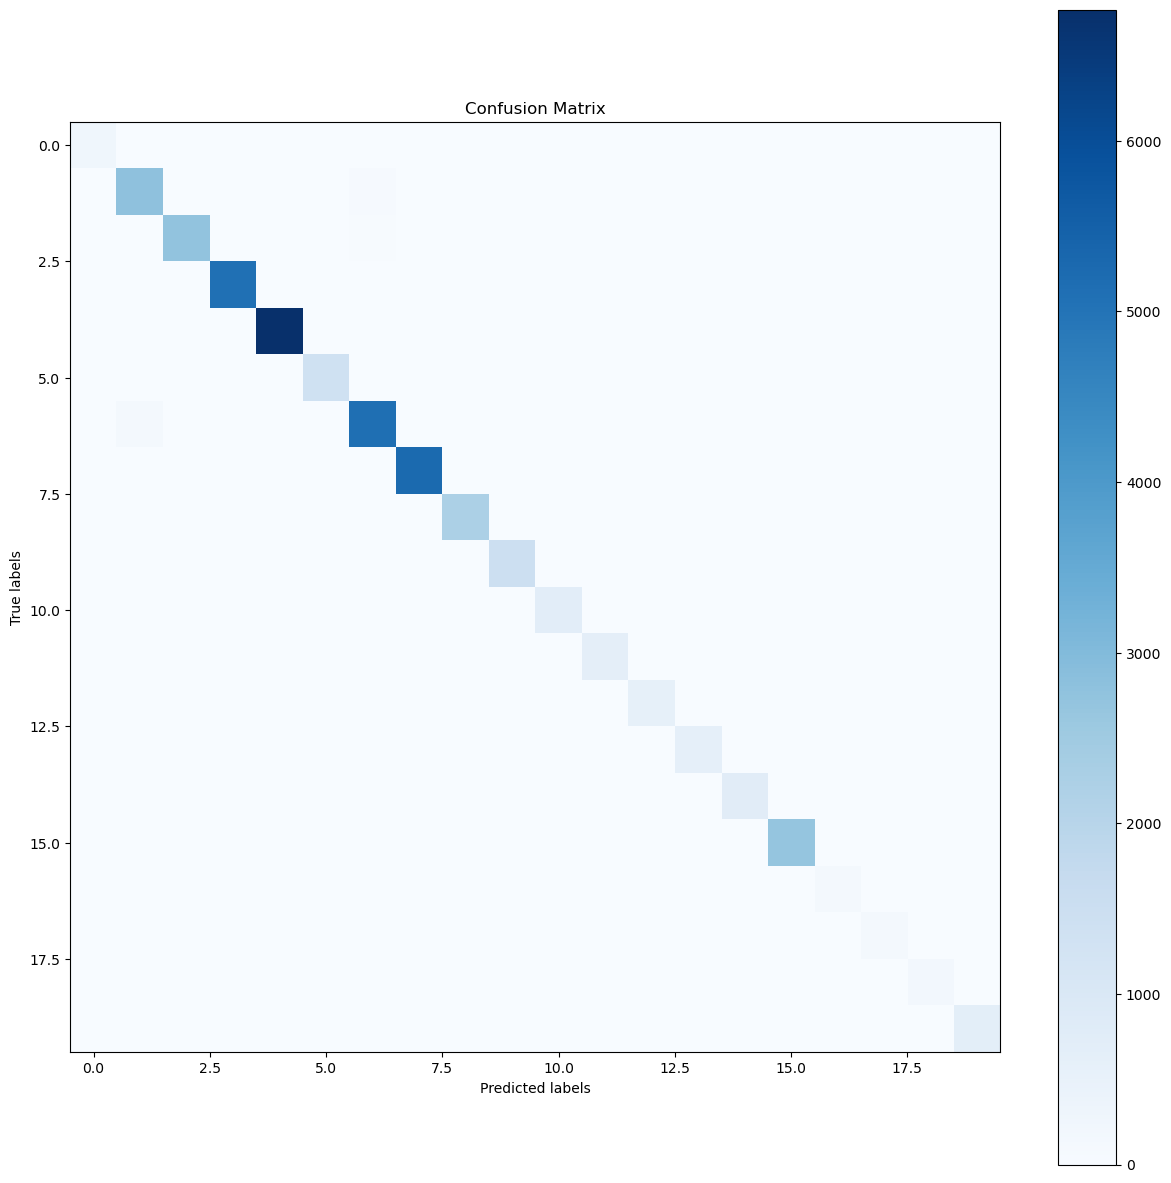

In [77]:
plt.figure(figsize=(15, 15))
plt.imshow(confusion_matrix, cmap='Blues')
plt.title('Confusion Matrix')
plt.colorbar()
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.show()

# Działający model zapisujemy do pliku.

In [81]:
model.save('equation_solver_v3.keras')